In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from RBM import RBM
from scipy.integrate import simps
from scipy import stats


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
data = np.genfromtxt('../data/data_1d2c_bal_seed14.dat')
data = torch.tensor((data+1)/2, device = device, dtype = dtype)


In [3]:
data.shape

torch.Size([6000, 1000])

In [18]:

lr = 0.01
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 100
Nh = 20
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V = V[:,0]
N = 20000
it_mean = 50

In [5]:
myRBM = RBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            w_hat = w_hat,
            N = N,
            it_mean = it_mean,
            V = V,
            TMCLearning = True
           )

In [6]:
myRBM.fit(data.T, ep_max)

IT  0
17.283262014389038
17.560485363006592
17.370328903198242
17.07879137992859
17.481587648391724
17.325709342956543
17.923680543899536
17.747706413269043
17.542551279067993
17.23416256904602
IT  1
17.157101154327393
17.145751237869263
17.411704540252686
17.359182119369507
17.057685136795044
17.527804136276245
17.386096954345703
18.48849320411682
18.794922351837158
17.628356456756592
IT  2
17.29690647125244
17.19657325744629
17.192295789718628
17.158831357955933
17.168167114257812
17.36507558822632
17.47938847541809
16.937674045562744
17.184380769729614
17.327730178833008
IT  3
17.340796947479248
17.46527338027954
17.069515228271484
16.963643550872803
16.972899436950684
16.938735008239746
16.924031496047974
16.916088342666626
17.257610082626343
16.953870058059692
IT  4
17.036271333694458
17.05549454689026
17.059635877609253
16.938708543777466
16.939332485198975
17.009143829345703
16.927168607711792
16.875486373901367
16.912822008132935
16.971892595291138
IT  5
16.991986751556396
17.0

In [7]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [35]:
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 1000), device=myRBM.device, dtype=myRBM.dtype))
si, _, _, _ = myRBM.Sampling(vinit.T, it_mcmc=100)


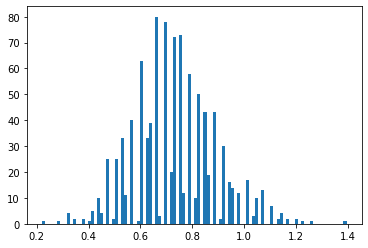

In [36]:
proj_gen = torch.mv(si, V)
plt.hist(proj_gen.cpu().numpy(), bins = 100);

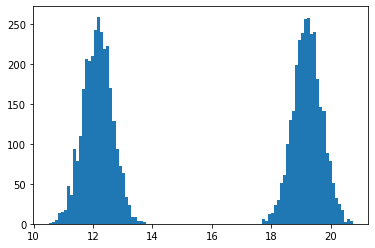

In [32]:
proj_data = torch.mv(data, V)
plt.hist(proj_data.cpu().numpy(), bins = 100);

In [19]:
_, S, _ = torch.svd(myRBM.W)

[]

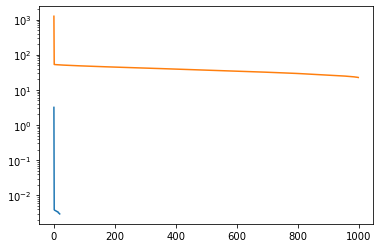

In [21]:
plt.plot(S.cpu())
plt.plot(S_d.cpu())
plt.semilogy()